In [157]:
import warnings
warnings.filterwarnings("ignore")

import re
import requests
import pandas as pd
import numpy as np
from time import sleep
from bs4 import BeautifulSoup
import pickle # for loading a dictionary from disk
from typing import Optional # typehint that value can also be None
import seaborn as sns
import matplotlib.pyplot as plt

import json,re,os
from urllib.parse import quote
from dataprep.clean import validate_country



pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [57]:
# fix the plos dataset
# fix the plos dataset
plos_df = pd.read_csv('../Data_Preprocessing/PLOS_final.csv',keep_default_na=False).drop(columns=['Unnamed: 0','index'])
AA_df = pd.read_csv('../Data_Preprocessing/AA_final.csv',keep_default_na=False).drop(columns=['Unnamed: 0','Unnamed: 0.1'])
Antiquity_df = pd.read_csv('../Data_Preprocessing/Antiquity_final.csv',keep_default_na=False).drop(columns=['Unnamed: 0','Unnamed: 0.1'])


data = pd.concat([plos_df,AA_df,Antiquity_df])

In [58]:
data

,DOI,Journal,Type,Title,Publish_Time,Issue_Time,Co Author,Author,Rank,Nationality,Abs_country,Abs_GPE,Abs_LOC,Nationality_clean,country_code,region_code,GPE,NORP,LOC,ORG,LANG,Co_Author
0,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Abay Namen,First,Kazakhstan,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],Kazakhstan,KZ,AS,['kazakhstan'],,,,,NaN
1,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Radu Iovita,Other,United States of America,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],United States,US,NA,['kazakhstan'],,,,,NaN
2,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Klaus G. Nickel,Other,Germany,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],Germany,DE,EU,['kazakhstan'],,,,,NaN
3,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Aristeidis Varis,Other,Germany,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],Germany,DE,EU,['kazakhstan'],,,,,NaN
4,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Zhaken Taimagambetov,Other,Kazakhstan,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],Kazakhstan,KZ,AS,['kazakhstan'],,,,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4973,https://doi.org/10.1017/S0003598X00066138,Antiquity,News and Notes,the use of henbane (hyoscyamus niger l.) as a ...,02 January 2015,March 2000,NaN,M. J. Bunting,Other,United Kingdom,[],[],[],United Kingdom,GB,EU,,,,,,True
4974,https://doi.org/10.1017/S0003598X00066138,Antiquity,News and Notes,the use of henbane (hyoscyamus niger l.) as a ...,02 January 2015,March 2000,NaN,P. Milburn,Communication,United Kingdom,[],[],[],United Kingdom,GB,EU,,,,,,True
4975,https://doi.org/10.1017/S0003598X0006614X,Antiquity,News and Notes,"taiwan, neolithic seafaring and austronesian o...",02 January 2015,March 2000,NaN,Barry V. Rolett,First,United States of America,[],[],['the Taiwan Strait' 'Pacific'],United States,US,NA,['taiwan'],['austronesian'],,,,True
4976,https://doi.org/10.1017/S0003598X0006614X,Antiquity,News and Notes,"taiwan, neolithic seafaring and austronesian o...",02 January 2015,March 2000,NaN,Wei-Chun Chen,Other,Taiwan,[],[],['the Taiwan Strait' 'Pacific'],Taiwan,TW,AS,['taiwan'],['austronesian'],,,,True


In [59]:
Target_country_info_df = data[['Abs_country','Abs_GPE','Abs_LOC','GPE','NORP','LOC','ORG','LANG']].reset_index(drop=True)

In [60]:
res = []
for i in range(len(Target_country_info_df)):
    temp = []
    row = Target_country_info_df.iloc[i]
    for info in row:
        if info !='[]' and info !=np.nan and info !='nan':
            temp += [info]
    res.append(temp)

# Filter out all the np.nan again
for i in range(len(res)):
    mask = [type(lst) == str for lst in res[i]]
    res[i]=np.array(res[i])[mask]
    
# Strip the each row (each row is a str(list of list))
for i in range(len(res)):
    res[i]=[STR.strip('][') for STR in res[i]]
    
# Flat the string    
for i in range(len(res)):
    LST = res[i]
    temp = ''
    for STR in LST:
        temp+=STR
    res[i] = temp.split("'")
    
Target_country_info_df['Target_info'] = res

Target_country_info_df.head()

,Abs_country,Abs_GPE,Abs_LOC,GPE,NORP,LOC,ORG,LANG,Target_info
0,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],['kazakhstan'],,,,,"[, the Inner Asian Mountain Corridor, , the Pa..."
1,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],['kazakhstan'],,,,,"[, the Inner Asian Mountain Corridor, , the Pa..."
2,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],['kazakhstan'],,,,,"[, the Inner Asian Mountain Corridor, , the Pa..."
3,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],['kazakhstan'],,,,,"[, the Inner Asian Mountain Corridor, , the Pa..."
4,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],['kazakhstan'],,,,,"[, the Inner Asian Mountain Corridor, , the Pa..."


In [61]:
data

,DOI,Journal,Type,Title,Publish_Time,Issue_Time,Co Author,Author,Rank,Nationality,Abs_country,Abs_GPE,Abs_LOC,Nationality_clean,country_code,region_code,GPE,NORP,LOC,ORG,LANG,Co_Author
0,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Abay Namen,First,Kazakhstan,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],Kazakhstan,KZ,AS,['kazakhstan'],,,,,NaN
1,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Radu Iovita,Other,United States of America,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],United States,US,NA,['kazakhstan'],,,,,NaN
2,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Klaus G. Nickel,Other,Germany,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],Germany,DE,EU,['kazakhstan'],,,,,NaN
3,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Aristeidis Varis,Other,Germany,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],Germany,DE,EU,['kazakhstan'],,,,,NaN
4,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Zhaken Taimagambetov,Other,Kazakhstan,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],Kazakhstan,KZ,AS,['kazakhstan'],,,,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4973,https://doi.org/10.1017/S0003598X00066138,Antiquity,News and Notes,the use of henbane (hyoscyamus niger l.) as a ...,02 January 2015,March 2000,NaN,M. J. Bunting,Other,United Kingdom,[],[],[],United Kingdom,GB,EU,,,,,,True
4974,https://doi.org/10.1017/S0003598X00066138,Antiquity,News and Notes,the use of henbane (hyoscyamus niger l.) as a ...,02 January 2015,March 2000,NaN,P. Milburn,Communication,United Kingdom,[],[],[],United Kingdom,GB,EU,,,,,,True
4975,https://doi.org/10.1017/S0003598X0006614X,Antiquity,News and Notes,"taiwan, neolithic seafaring and austronesian o...",02 January 2015,March 2000,NaN,Barry V. Rolett,First,United States of America,[],[],['the Taiwan Strait' 'Pacific'],United States,US,NA,['taiwan'],['austronesian'],,,,True
4976,https://doi.org/10.1017/S0003598X0006614X,Antiquity,News and Notes,"taiwan, neolithic seafaring and austronesian o...",02 January 2015,March 2000,NaN,Wei-Chun Chen,Other,Taiwan,[],[],['the Taiwan Strait' 'Pacific'],Taiwan,TW,AS,['taiwan'],['austronesian'],,,,True


In [62]:
 from collections import Counter
# Pick the most frequent valid country as target
info = Target_country_info_df['Target_info']

target_country = []
for LST in info:
    mask = [validate_country(country,input_format="name") for country in LST]
    valid_list = np.array(LST)[mask]
    target_country.append(Counter(valid_list).most_common(1))
    
for i in range(len(target_country)):
    temp = target_country[i]
    if len(temp)>0:
        target_country[i] = temp[0][0]
    else:
        target_country[i] = np.nan

Target_country_info_df['Target_Country'] =  target_country
Target_country_info_df['region_code'] = list(data['region_code'])
Target_country_info_df['Journal'] = list(data['Journal'])
Target_country_info_df['country_code'] = list(data['country_code'])
Target_country_info_df['Issue_Time'] = list(data['Issue_Time'])
Target_country_info_df['Year'] = [time.split(' ')[-1] for time in Target_country_info_df.Issue_Time]



from dataprep.clean import clean_country
Target_country_info_df = clean_country(Target_country_info_df,'Target_Country') 


  0%|                                                     | 0/8 [00:00<?, ?it/s]

Country Cleaning Report:
	1050 values cleaned (8.59%)
Result contains 6529 (53.43%) values in the correct format and 5690 null values (46.57%)


In [63]:
import pycountry_convert as pc

Target_country_info_df = Target_country_info_df[Target_country_info_df['Target_Country_clean'].apply(lambda x:type(x)==str)]

res=[]
for i in Target_country_info_df.Target_Country_clean:
    try:
        res.append(pc.country_name_to_country_alpha2(i, cn_name_format="default"))
    except KeyError:
        res.append(np.nan)

Target_country_info_df['Target_country_code'] = res


mask = [type(cc) == str for cc in res]
Target_country_info_df = Target_country_info_df[mask]
       
final_code=[]
for CC in Target_country_info_df.Target_country_code:
    try:
        final_code.append(pc.country_alpha2_to_continent_code(CC))
    except KeyError:
        final_code.append(np.nan)

Target_country_info_df['Target_cont_code'] = final_code
 

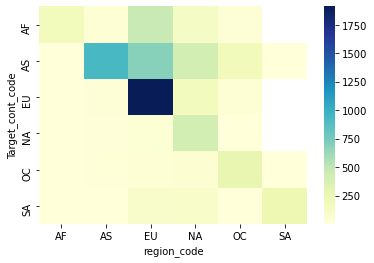

In [64]:
double_index_df = Target_country_info_df.groupby(['region_code','Target_cont_code']).count()
temp = double_index_df.reset_index().pivot(columns='region_code',index='Target_cont_code',values='Abs_country')

sns.color_palette()
sns.heatmap(temp, cmap="YlGnBu")
plt.show()

In [65]:
data = Target_country_info_df.groupby(['country_code','Target_country_code']).count()
data.reset_index().pivot(columns='country_code',index='Target_country_code',values='Abs_country')

#[Target_country_info_df.Journal == 'PLOS ONE']

country_code,AE,AL,AM,AR,AS,AT,AU,AZ,BE,BG,BJ,BR,BW,CA,CH,CL,CM,CN,CO,CR,CU,CY,CZ,DE,DK,DO,EC,EE,EG,ES,ET,FI,FR,GB,GE,GI,GR,GT,GU,HK,HN,HR,HU,ID,IE,IL,IN,IQ,IR,IS,...,MG,MM,MN,MX,MY,NA,NC,NE,NG,NI,NL,NO,NP,NZ,OM,PA,PE,PF,PG,PH,PK,PL,PR,PT,QA,RO,RS,RU,SA,SD,SE,SG,SI,SK,SN,TH,TJ,TR,TW,TZ,UA,US,UY,UZ,VN,VU,YE,ZA,ZM,ZW
Target_country_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
AL,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AM,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,8.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YE,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
ZA,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,9.0,16.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2

In [159]:
data = Target_country_info_df[Target_country_info_df.Journal == 'Antiquity'].groupby(['region_code','Target_cont_code']).count()
data.reset_index().pivot(columns='region_code',index='Target_cont_code',values='Abs_country')

region_code,AF,AS,EU,NA,OC,SA
Target_cont_code,,,,,,
AF,63.0,5.0,167.0,48.0,3.0,NaN
AS,NaN,403.0,360.0,174.0,128.0,2.0
EU,NaN,11.0,711.0,80.0,9.0,NaN
NA,NaN,3.0,22.0,106.0,NaN,NaN
OC,NaN,9.0,10.0,15.0,136.0,NaN
SA,1.0,2.0,39.0,59.0,1.0,84.0


In [158]:
data = Target_country_info_df[Target_country_info_df.Journal == 'American Antiquity'].groupby(['region_code','Target_cont_code']).count()
data.reset_index().pivot(columns='region_code',index='Target_cont_code',values='Abs_country')

region_code,AF,AS,EU,NA,OC,SA
Target_cont_code,,,,,,
AF,NaN,NaN,4.0,7.0,NaN,NaN
AS,NaN,6.0,4.0,50.0,1.0,NaN
EU,NaN,NaN,3.0,7.0,2.0,NaN
NA,3.0,NaN,6.0,106.0,NaN,NaN
OC,NaN,NaN,3.0,7.0,7.0,NaN
SA,NaN,NaN,NaN,NaN,NaN,2.0


In [67]:
data = Target_country_info_df[Target_country_info_df.Journal == 'PLOS ONE'].groupby(['region_code','Target_cont_code']).count()
data.reset_index().pivot(columns='region_code',index='Target_cont_code',values='Abs_country')

region_code,AF,AS,EU,NA,OC,SA
Target_cont_code,,,,,,
AF,112.0,26.0,297.0,80.0,22.0,NaN
AS,7.0,520.0,326.0,181.0,64.0,NaN
EU,8.0,19.0,1197.0,83.0,21.0,NaN
NA,NaN,6.0,11.0,198.0,3.0,NaN
OC,4.0,9.0,19.0,28.0,128.0,1.0
SA,NaN,3.0,54.0,43.0,6.0,143.0


In [160]:
# region

data = Target_country_info_df.groupby(['Target_cont_code','Journal']).count()
data.reset_index().pivot(columns='Journal',index='Target_cont_code',values='Abs_country')

Journal,American Antiquity,Antiquity,PLOS ONE
Target_cont_code,,,
AF,11,286,537
AS,61,1067,1098
EU,12,811,1328
NA,115,131,218
OC,17,170,189
SA,2,186,249


In [163]:
data = pd.concat([plos_df,AA_df,Antiquity_df])
data = data.groupby(['region_code','Journal']).count()
data.reset_index().pivot(columns='Journal',index='region_code',values='DOI')

Journal,American Antiquity,Antiquity,PLOS ONE
region_code,,,
AF,6,93,185
AS,7,609,903
EU,58,2825,3235
NA,1080,940,1186
OC,13,378,344
SA,2,133,222


In [69]:
double_index_df = Target_country_info_df.groupby(['region_code','Target_cont_code']).count()

In [70]:
temp = Target_country_info_df.groupby(['Journal','Target_Country']).count()[['region_code']]
temp.loc['American Antiquity'].sort_values(by = 'region_code',ascending = False).head(20)

,region_code
Target_Country,
United States,46
Mexico,35
Canada,22
Georgia,21
turkey,9
Australia,8
China,7
china,7
Spain,6


In [71]:
temp.loc['Antiquity'].sort_values(by = 'region_code',ascending = False).head(20)

,region_code
Target_Country,
China,239
Spain,108
Australia,79
France,64
Peru,62
Italy,61
Egypt,57
Thailand,54
Syria,51


In [72]:
temp.loc['PLOS ONE'].sort_values(by = 'region_code',ascending = False).head()

,region_code
Target_Country,
China,247
Italy,229
France,208
Israel,181
Spain,158


In [73]:
temp = Target_country_info_df.groupby(['Journal','Target_Country']).count()[['region_code']]
temp

region_code
Journal            Target_Country             
American Antiquity Anguilla                  5
                   Argentina                 2
                   Australia                 8
                   Bermuda                   1
                   Burkina Faso              1
...                                        ...
PLOS ONE           spain                    42
                   tanzania                 33
                   tonga                     2
                   turkey                   33
                   zimbabwe                  5

[344 rows x 1 columns]

## III. EDA and Plots

In [74]:
countrymax = Antiquity_df.groupby(['Nationality']).size().nlargest(10)
countrysize = len(Antiquity_df.Nationality.unique())
countrymax = countrymax.to_frame()
countrymax = countrymax.rename(columns= {0: 'count'})
countrymax

,count
Nationality,
United Kingdom,1339
United States of America,817
Australia,322
France,309
Germany,216
China,192
Spain,158
Italy,99
Canada,85


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

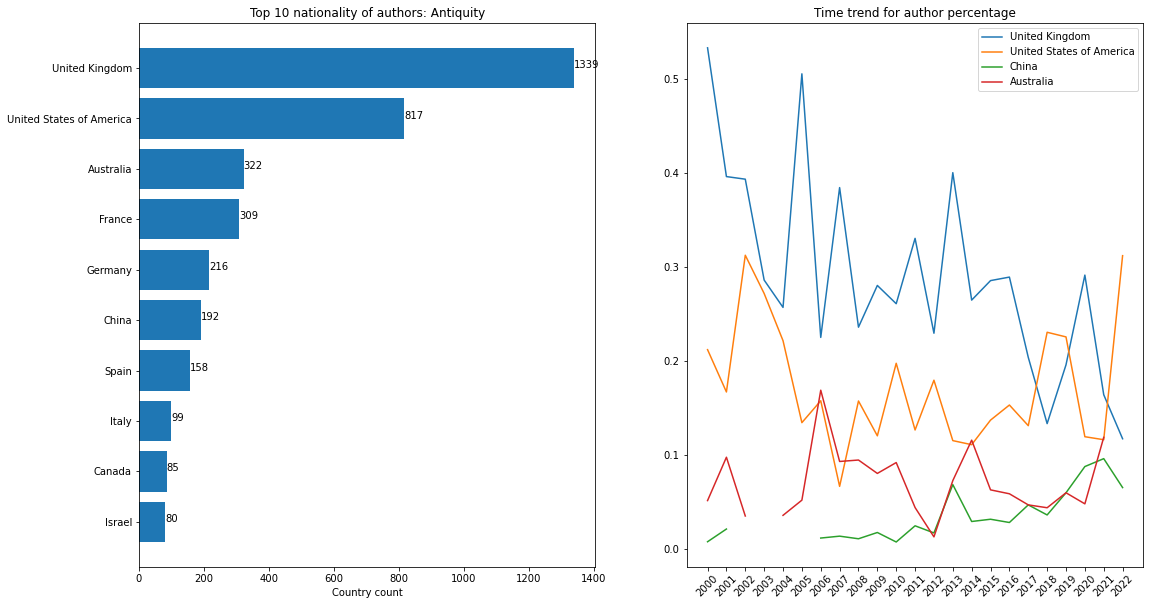

In [75]:
fig, ax = plt.subplots(1,2, figsize = (18,10))
axs = ax.flatten()
y = countrymax['count'].values[::-1]
x = countrymax.index[::-1]
axs[0].barh(x, y)

for index, value in enumerate(y):
    axs[0].text(value, index, str(value))

axs[0].set_xlabel('Country count')
axs[0].set_title('Top 10 nationality of authors: Antiquity')

Antiquity_df['Year'] = [time.split(' ')[-1] for time in Antiquity_df.Issue_Time]
year_dic ={year:np.nan for year in np.unique(Antiquity_df['Year'])}
year_series = pd.Series(data = year_dic)
for state in ['United Kingdom','United States of America','China','Australia']:
    data = Antiquity_df[Antiquity_df.Nationality == state]
    data['Year'] = [time.split(' ')[-1] for time in data.Issue_Time]
    ratio_series = data.groupby('Year').count()['Author']/Antiquity_df.groupby('Year').count()['Author']
    for i in ratio_series.index:
        year_series[i] = ratio_series[i]
    axs[1].plot(year_series, label = state)
    year_series = pd.Series(data = year_dic)
    axs[1].legend()
axs[1].set_xticklabels(year_series.index, rotation = 45)
axs[1].set_title('Time trend for author percentage')

plt.show()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

                          count
Nationality                    
United States of America    969
Canada                      108
United Kingdom               34
France                        9
Australia                     7
Spain                         7
South Africa                  6
China                         5
New Zealand                   5
Germany                       3


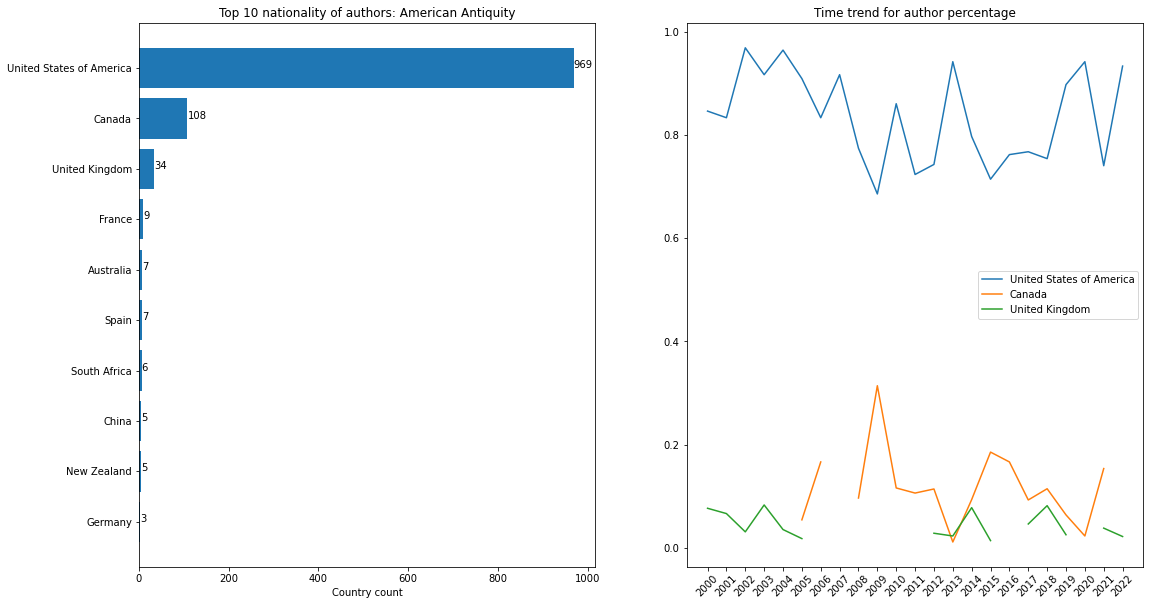

In [76]:
countrymax = AA_df.groupby(['Nationality']).size().nlargest(10)
countrysize = len(AA_df.Nationality.unique())
countrymax = countrymax.to_frame()
countrymax = countrymax.rename(columns= {0: 'count'})
print(countrymax)

fig, ax = plt.subplots(1,2, figsize = (18,10))
axs = ax.flatten()
y = countrymax['count'].values[::-1]
x = countrymax.index[::-1]
axs[0].barh(x, y)

for index, value in enumerate(y):
    axs[0].text(value, index, str(value))

axs[0].set_xlabel('Country count')
axs[0].set_title('Top 10 nationality of authors: American Antiquity')

AA_df['Year'] = [time.split(' ')[-1] for time in AA_df.Issue_Time]
year_dic ={year:np.nan for year in np.unique(AA_df['Year'])}
year_series = pd.Series(data = year_dic)

for state in ['United States of America','Canada','United Kingdom']:
    data = AA_df[AA_df.Nationality == state]
    data['Year'] = [time.split(' ')[-1] for time in data.Issue_Time]
    ratio_series = data.groupby('Year').count()['Author']/AA_df.groupby('Year').count()['Author']
    for i in ratio_series.index:
        year_series[i] = ratio_series[i]
    axs[1].plot(year_series, label = state)
    year_series = pd.Series(data = year_dic)
    axs[1].legend()
axs[1].set_xticklabels(year_series.index, rotation = 45)
axs[1].set_title('Time trend for author percentage')

plt.show()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

                          count
Nationality                    
United States of America    934
United Kingdom              616
Germany                     494
France                      470
Spain                       433
Italy                       349
China                       307
Australia                   270
Israel                      267
Canada                      208


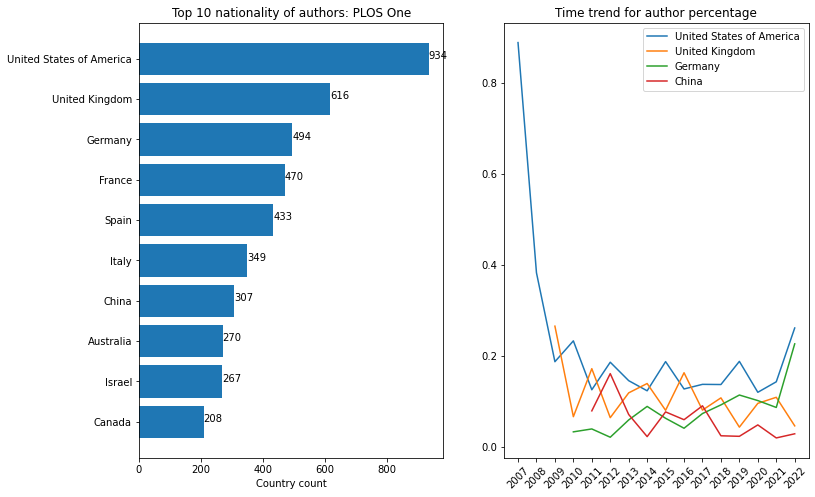

In [77]:
countrymax = plos_df.groupby(['Nationality']).size().nlargest(10)
countrysize = len(plos_df.Nationality.unique())
countrymax = countrymax.to_frame()
countrymax = countrymax.rename(columns= {0: 'count'})
print(countrymax)

fig, ax = plt.subplots(1,2, figsize = (12,8))
axs = ax.flatten()
y = countrymax['count'].values[::-1]
x = countrymax.index[::-1]
axs[0].barh(x, y)

for index, value in enumerate(y):
    axs[0].text(value, index, str(value))
    


axs[0].set_xlabel('Country count')
axs[0].set_title('Top 10 nationality of authors: PLOS One')

plos_df['Year'] = [time.split(' ')[-1] for time in plos_df.Issue_Time]
year_dic ={year:np.nan for year in np.unique(plos_df['Year'])}
year_series = pd.Series(data = year_dic)#

for state in ['United States of America','United Kingdom','Germany','China']:
    data = plos_df[plos_df.Nationality == state]
    data['Year'] = [time.split(' ')[-1] for time in data.Issue_Time]
    ratio_series = data.groupby('Year').count()['Author']/plos_df.groupby('Year').count()['Author']
    for i in ratio_series.index:
        year_series[i] = ratio_series[i]
    axs[1].plot(year_series, label = state)
    year_series = pd.Series(data = year_dic)
    
axs[1].set_xticklabels(year_series.index, rotation = 45)
axs[1].set_title('Time trend for author percentage')
axs[1].legend()

plt.show()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

                          count
Nationality                    
United States of America   2720
United Kingdom             1989
France                      788
Germany                     713
Australia                   599
Spain                       598
China                       504
Italy                       448
Canada                      401
Israel                      348


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


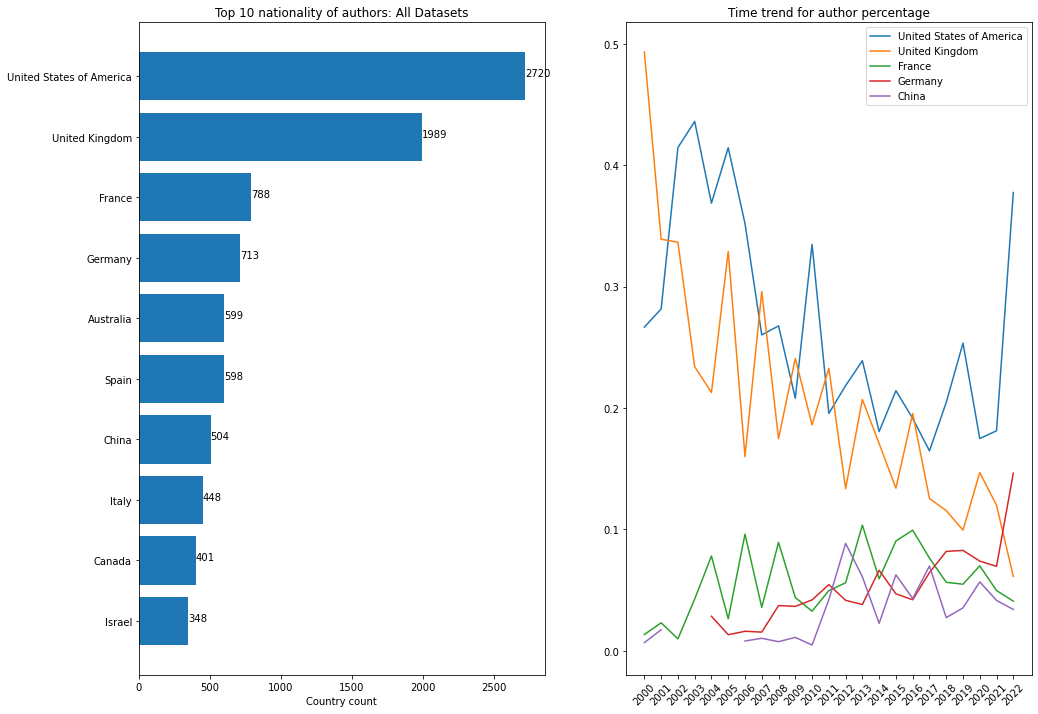

In [78]:
dataall = pd.concat([plos_df,AA_df,Antiquity_df])
countrymax = dataall.groupby(['Nationality']).size().nlargest(10)
countrysize = len(dataall.Nationality.unique())
countrymax = countrymax.to_frame()
countrymax = countrymax.rename(columns= {0: 'count'})
print(countrymax)

fig, ax = plt.subplots(1,2, figsize = (16,12))
axs = ax.flatten()
y = countrymax['count'].values[::-1]
x = countrymax.index[::-1]
axs[0].barh(x, y)
for index, value in enumerate(y):
    axs[0].text(value, index, str(value))

axs[0].set_xlabel('Country count')
axs[0].set_title('Top 10 nationality of authors: All Datasets')


dataall['Year'] = [time.split(' ')[-1] for time in dataall.Issue_Time]
year_dic ={year:np.nan for year in np.unique(dataall['Year'])}
year_series = pd.Series(data = year_dic)#

for state in ['United States of America','United Kingdom','France','Germany','China']:
    data = dataall[dataall.Nationality == state]
    data['Year'] = [time.split(' ')[-1] for time in data.Issue_Time]
    ratio_series = data.groupby('Year').count()['Author']/dataall.groupby('Year').count()['Author']
    for i in ratio_series.index:
        year_series[i] = ratio_series[i]
    axs[1].plot(year_series, label = state)
    year_series = pd.Series(data = year_dic)
    
axs[1].set_xticklabels(year_series.index, rotation = 45)
axs[1].set_title('Time trend for author percentage')
axs[1].legend()

plt.show()

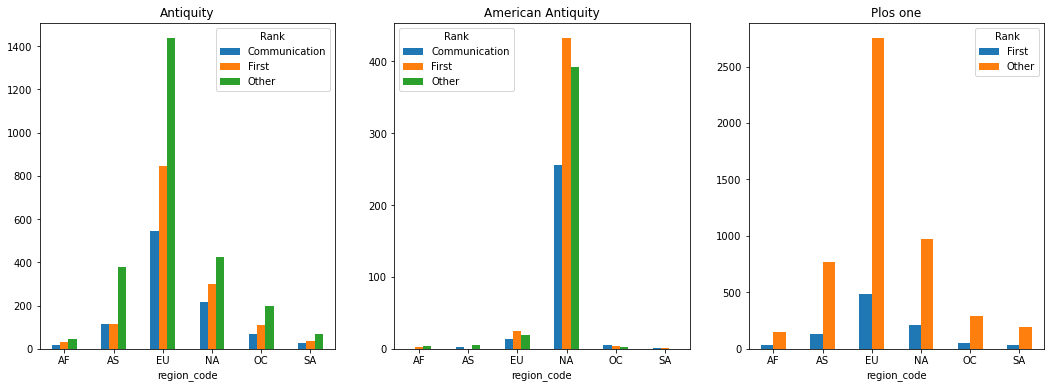

In [79]:
fig, ax = plt.subplots(1,3, figsize = (18,6))
axis = ax.flatten()

Antiquity_df.groupby(['region_code', 'Rank']).size().unstack(fill_value = 0).plot(ax=axis[0],kind='bar',rot=0)
axis[0].set_title('Antiquity')

AA_df.groupby(['region_code', 'Rank']).size().unstack(fill_value = 0).plot(ax=axis[1],kind='bar',rot=0)
axis[1].set_title('American Antiquity')

plos_df.groupby(['region_code', 'Rank']).size().unstack(fill_value = 0).plot(ax=axis[2],kind='bar',rot=0)
axis[2].set_title('Plos one')

plt.show()

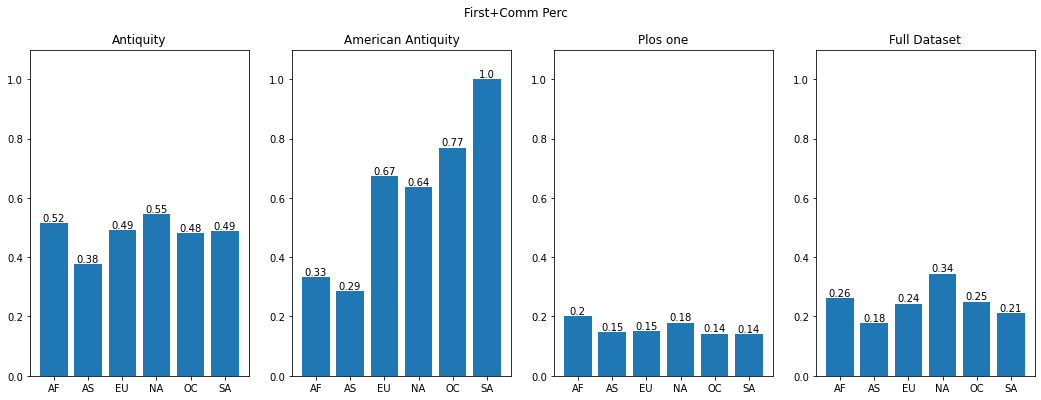

In [80]:


fig, ax = plt.subplots(1,4, figsize = (18,6))
axis = ax.flatten()

temp = Antiquity_df.groupby(['region_code', 'Rank']).count()['DOI'].unstack(fill_value = 0)
y = (temp['Communication']+ temp['First'])/(temp['Communication']+ temp['First'] + temp['Other']).values
x = temp.index
axis[0].bar(x,y)
for i in range(len(y)):
    axis[0].annotate(str(np.round(y[i],2)), xy=(x[i],y[i]), ha='center', va='bottom')
axis[0].set_ylim(0,1.1)
axis[0].set_title('Antiquity')

temp = AA_df.groupby(['region_code', 'Rank']).count()['DOI'].unstack(fill_value = 0)
y = (temp['Communication']+ temp['First'])/(temp['Communication']+ temp['First'] + temp['Other']).values
x = temp.index
axis[1].bar(x, y)
for i in range(len(y)):
    axis[1].annotate(str(np.round(y[i],2)), xy=(x[i],y[i]), ha='center', va='bottom')
axis[1].set_title('American Antiquity')
axis[1].set_ylim(0,1.1)


temp = plos_df.groupby(['region_code', 'Rank']).count()['DOI'].unstack(fill_value = 0)
y = ((temp['First'])/(temp['First'] + temp['Other'])).values
x = temp.index
axis[2].bar(x,y)
for i in range(len(y)):
    axis[2].annotate(str(np.round(y[i],2)), xy=(x[i],y[i]), ha='center', va='bottom')
axis[2].set_title('Plos one')
axis[2].set_ylim(0,1.1)


data = pd.concat([plos_df,AA_df,Antiquity_df])
temp = data.groupby(['region_code', 'Rank']).count()['DOI'].unstack(fill_value = 0)

y = ((temp['First'])/(temp['First'] + temp['Other'])).values
x = temp.index
plt.bar(x,y)
for i in range(len(y)):
    axis[3].annotate(str(np.round(y[i],2)), xy=(x[i],y[i]), ha='center', va='bottom')
plt.ylim(0,1.1)
plt.title('Full Dataset')


plt.suptitle('First+Comm Perc')
plt.show()


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

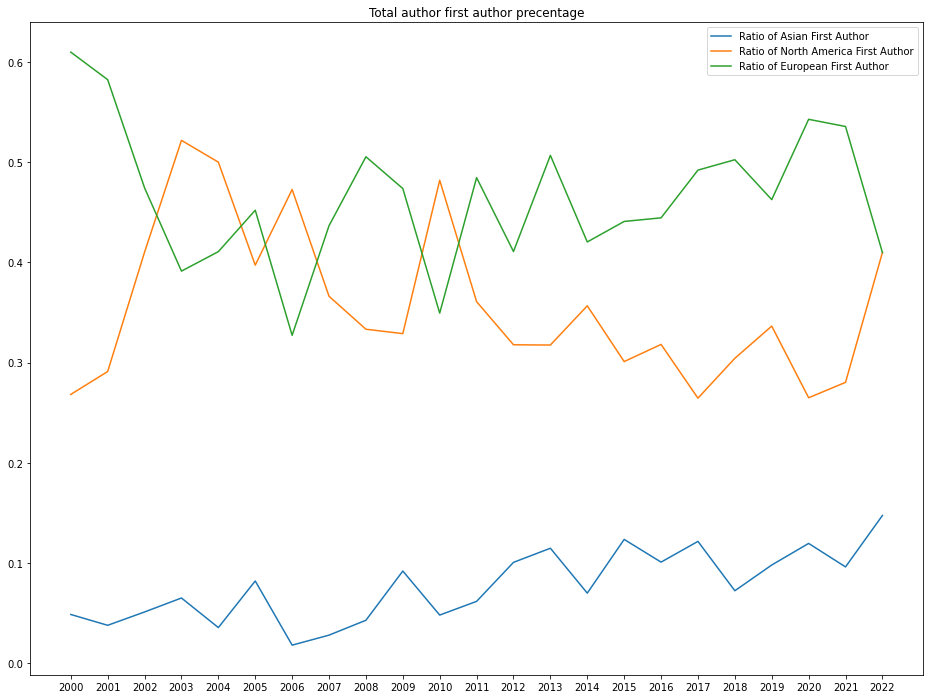

In [81]:
# Number of Region‘s First author/ Toal number of First author （number of DOI）
plt.figure(figsize=(16, 12))
dataall = pd.concat([plos_df,AA_df,Antiquity_df])

temp = dataall.groupby(['Rank','region_code','Year']).count()
all_first_series = dataall.groupby(['Rank','Year']).count().loc['First']['Author']


plt.plot(temp.loc['First','AS']['Author']/ all_first_series, label = 'Ratio of Asian First Author')
plt.plot(temp.loc['First','NA']['Author']/ all_first_series, label = 'Ratio of North America First Author')
plt.plot(temp.loc['First','EU']['Author']/ all_first_series, label = 'Ratio of European First Author')
plt.title('Total author first author precentage')
plt.legend()
plt.show()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

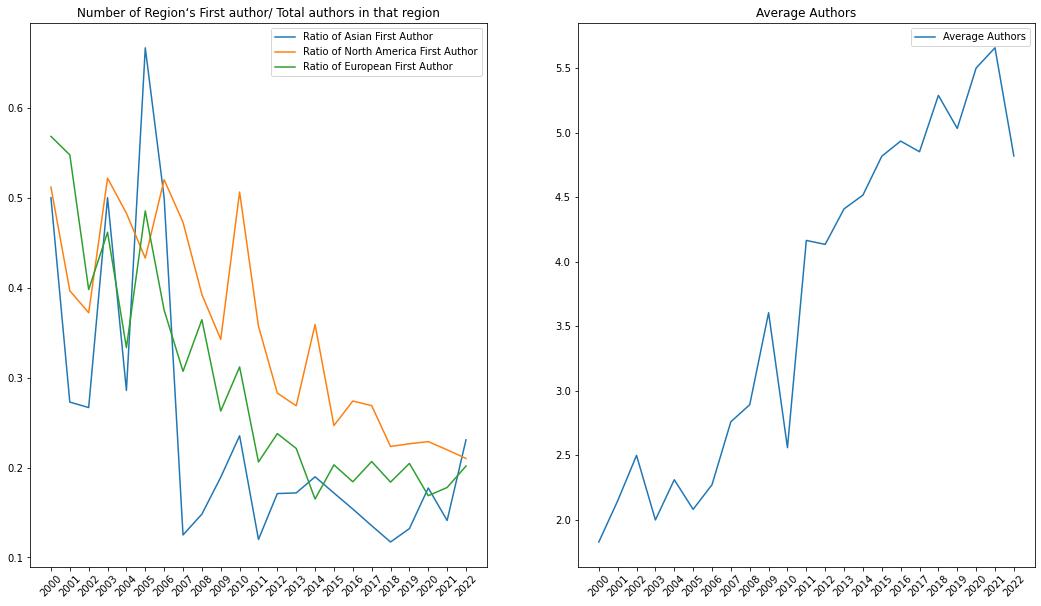

In [82]:
# Number of Region‘s First author/ Toal authors in that region

year_list = np.unique(dataall.Year)

fig, ax = plt.subplots(1,2, figsize = (18,10))
axs = ax.flatten()

dataall = pd.concat([plos_df,AA_df,Antiquity_df])

temp = dataall.groupby(['Rank','region_code','Year']).count()
all_first_series = dataall.groupby(['region_code','Year']).count()

axs[0].plot(temp.loc['First','AS']['Author']/ all_first_series.loc['AS']['Author'], label = 'Ratio of Asian First Author')
axs[0].plot(temp.loc['First','NA']['Author']/ all_first_series.loc['NA']['Author'], label = 'Ratio of North America First Author')
axs[0].plot(temp.loc['First','EU']['Author']/ all_first_series.loc['EU']['Author'], label = 'Ratio of European First Author')
axs[0].set_title('Number of Region‘s First author/ Total authors in that region')
axs[0].set_xticklabels(year_list, rotation = 45)
axs[0].legend()


temp = dataall.groupby(['Year','DOI']).count()['Author']
year_average = [np.mean(temp.loc[year]) for year in np.unique(dataall.Year)]
axs[1].plot(year_list,year_average, label = 'Average Authors')
axs[1].set_title('Average Authors')
axs[1].set_xticklabels(year_list, rotation = 45)
axs[1].legend()


plt.show()

In [83]:
'''
# total author + regional author time trend

fig, ax = plt.subplots(1,3, figsize = (18,6))
axis = ax.flatten()
#################
time = plos_df.groupby('Issue_Time').count()[['Author']].index
Total_author = plos_df.groupby('Issue_Time').count()['Author']

plos_df['Issue_Time']=pd.to_datetime(plos_df['Issue_Time'])
axis[0].plot(time,Total_author,label = 'Total_Author')
axis[0].plot(plos_df[plos_df.region_code == 'AS'].groupby('Issue_Time').count()[['Author']],label = 'AS_Author')
axis[0].legend()
axis[0].set_title('Plos one')
############
time = AA_df.groupby('Issue_Time').count()[['Author']].index
Total_author = AA_df.groupby('Issue_Time').count()['Author']

AA_df['Issue_Time']=pd.to_datetime(AA_df['Issue_Time'])
axis[1].plot(time,Total_author,label = 'Total_Author')
as_author = AA_df[AA_df.region_code == 'AS'].groupby('Issue_Time').count()[['Author']]
axis[1].plot(as_author,label = 'AS_Author')
axis[1].legend()
axis[1].set_title('American Antiquity')


#########
time = Antiquity_df.groupby('Issue_Time').count()[['Author']].index
Total_author = Antiquity_df.groupby('Issue_Time').count()['Author']

Antiquity_df['Issue_Time']=pd.to_datetime(Antiquity_df['Issue_Time'])
axis[2].plot(time,Total_author,label = 'Total_Author')
as_author = Antiquity_df[Antiquity_df.region_code == 'AS'].groupby('Issue_Time').count()[['Author']]
axis[2].plot(as_author,label = 'AS_Author')
axis[2].legend()
axis[2].set_title('Antiquity')

plt.show()

'''

"\n# total author + regional author time trend\n\nfig, ax = plt.subplots(1,3, figsize = (18,6))\naxis = ax.flatten()\n#################\ntime = plos_df.groupby('Issue_Time').count()[['Author']].index\nTotal_author = plos_df.groupby('Issue_Time').count()['Author']\n\nplos_df['Issue_Time']=pd.to_datetime(plos_df['Issue_Time'])\naxis[0].plot(time,Total_author,label = 'Total_Author')\naxis[0].plot(plos_df[plos_df.region_code == 'AS'].groupby('Issue_Time').count()[['Author']],label = 'AS_Author')\naxis[0].legend()\naxis[0].set_title('Plos one')\n############\ntime = AA_df.groupby('Issue_Time').count()[['Author']].index\nTotal_author = AA_df.groupby('Issue_Time').count()['Author']\n\nAA_df['Issue_Time']=pd.to_datetime(AA_df['Issue_Time'])\naxis[1].plot(time,Total_author,label = 'Total_Author')\nas_author = AA_df[AA_df.region_code == 'AS'].groupby('Issue_Time').count()[['Author']]\naxis[1].plot(as_author,label = 'AS_Author')\naxis[1].legend()\naxis[1].set_title('American Antiquity')\n\n\n####

In [84]:
#temp = plos_df.groupby(['region_code', 'Rank']).count()['DOI'].unstack(fill_value = 0)
#y = (temp['Communication']+ temp['First'])/(temp['Communication']+ temp['First'] + temp['Other']).values


temp = plos_df.groupby(['region_code', 'Rank']).count()['DOI'].unstack(fill_value = 0)
y = ((temp['First'])/(temp['First'] + temp['Other'])).values


In [85]:
temp #4978 0.48

Rank,First,Other
region_code,,
AF,37,148
AS,133,770
EU,485,2750
NA,213,973
OC,49,295
SA,31,191


In [86]:
Target_country_info_df.columns

Index(['Abs_country', 'Abs_GPE', 'Abs_LOC', 'GPE', 'NORP', 'LOC', 'ORG',
       'LANG', 'Target_info', 'Target_Country', 'region_code', 'Journal',
       'country_code', 'Issue_Time', 'Year', 'Target_Country_clean',
       'Target_country_code', 'Target_cont_code'],
      dtype='object')

In [87]:
len(Target_country_info_df[Target_country_info_df['Journal'] == 'PLOS ONE'].Target_Country_clean.unique())


107

In [88]:
AA_df

,DOI,Journal,Type,Title,Publish_Time,Issue_Time,Co_Author,Author,Rank,Nationality,Abs_country,Abs_GPE,Abs_LOC,Nationality_clean,country_code,region_code,GPE,NORP,LOC,ORG,LANG,Year
0,https://doi.org/10.1017/aaq.2021.115,American Antiquity,Article,direct evidence for geophyte exploitation in t...,02 November 2021,April 2022,True,Kaley Joyce,First,United States of America,['10'],['Wyoming'],['the Wyoming Basin' 'the Wyoming Basin'],United States,US,NA,,,['the wyoming basin'],,,2022
1,https://doi.org/10.1017/aaq.2021.115,American Antiquity,Article,direct evidence for geophyte exploitation in t...,02 November 2021,April 2022,True,Lisbeth A. Louderback,Other,United States of America,['10'],['Wyoming'],['the Wyoming Basin' 'the Wyoming Basin'],United States,US,NA,,,['the wyoming basin'],,,2022
2,https://doi.org/10.1017/aaq.2021.115,American Antiquity,Article,direct evidence for geophyte exploitation in t...,02 November 2021,April 2022,True,Erick Robinson,Communication,United States of America,['10'],['Wyoming'],['the Wyoming Basin' 'the Wyoming Basin'],United States,US,NA,,,['the wyoming basin'],,,2022
3,https://doi.org/10.1017/aaq.2021.119,American Antiquity,Article,"regional conflict, ceramic senescence, and paw...",02 December 2021,April 2022,True,Margaret E. Beck,First,United States of America,[],['Kitkahahki Town'],['the Central Great Plains'],United States,US,NA,,,,,,2022
4,https://doi.org/10.1017/aaq.2021.119,American Antiquity,Article,"regional conflict, ceramic senescence, and paw...",02 December 2021,April 2022,True,Richard L. Josephs,Other,United States of America,[],['Kitkahahki Town'],['the Central Great Plains'],United States,US,NA,,,,,,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,https://doi.org/10.2307/2694531,American Antiquity,Articles,"pots, parties, and politics: communal feasting...",20 January 2017,July 2000,False,James M. Potter,First,United States of America,['850'],['A.D.'],['Southwest' 'Southwest communities' 'Southwest'],United States,US,NA,,,['the american southwest'],,,2000
1162,https://doi.org/10.2307/2694057,American Antiquity,Articles,"questions of evidence, legitimacy, and the (di...",20 January 2017,April 2000,False,Alison Wylie,First,United States of America,[],[],[],United States,US,NA,,,,,,2000
1163,https://doi.org/10.2307/2694058,American Antiquity,Articles,archaeology and native north american oral tra...,20 January 2017,April 2000,False,Ronald J. Mason,First,United States of America,[],[],[],United States,US,NA,,['north american'],,,,2000
1164,https://doi.org/10.2307/2694059,American Antiquity,Articles,ancient history in the new world: integrating ...,20 January 2017,April 2000,False,Roger C. Echo-Hawk,First,United States of America,[],['North Dakota'],['North America'],United States,US,NA,,,,,,2000


In [89]:
Target_country_info_df.Target_Country_clean.unique()

array(['Kazakhstan', 'France', 'Germany', 'China', 'South Africa',
       'Armenia', 'Japan', 'Georgia', 'Taiwan', 'Morocco', 'Mexico',
       'Afghanistan', 'Hungary', 'Tajikistan', 'Spain', 'Cyprus',
       'Israel', 'Italy', 'Netherlands', 'Australia', 'Iran', 'Lebanon',
       'Tanzania', 'Turkey', 'Jordan', 'Chile', 'Zambia', 'Botswana',
       'Denmark', 'Colombia', 'Guatemala', 'Sweden', 'Slovakia',
       'Mongolia', 'Egypt', 'Belize', 'Sudan', 'Brazil', 'Croatia',
       'Laos', 'India', 'Ukraine', 'Norway', 'Iceland', 'Ethiopia',
       'Switzerland', 'Senegal', 'Argentina', 'Madagascar', 'Russia',
       'Jersey', 'Lithuania', 'Kenya', 'Yemen', 'United States',
       'Portugal', 'Finland', 'Canada', 'Poland', 'Peru', 'Serbia',
       'Namibia', 'Greece', 'Sri Lanka', 'Bahamas', 'Tonga', 'Vietnam',
       'Dominican Republic', 'Barbados', 'Thailand', 'Romania',
       'New Zealand', 'Ireland', 'Cambodia', 'Gibraltar',
       'Czech Republic', 'Iraq', 'Uzbekistan', 'Indonesia

In [165]:
# For each journal, the top 10 popular destination

AA_data=Target_country_info_df[Target_country_info_df.Journal == 'American Antiquity']
countrymax = AA_data.groupby(['Target_Country_clean']).size().nlargest(10)
countrysize = len(AA_data.Target_Country_clean.unique())
countrymax = countrymax.to_frame()
countrymax_AA = countrymax.rename(columns= {0: 'count'})
countrymax_AA

,count
Target_Country_clean,
United States,47
Mexico,39
Canada,22
Georgia,21
China,14
Turkey,11
Jordan,9
Australia,8
Spain,6


In [166]:
A_data=Target_country_info_df[Target_country_info_df.Journal == 'Antiquity']
countrymax = A_data.groupby(['Target_Country_clean']).size().nlargest(10)
countrysize = len(A_data.Target_Country_clean.unique())
countrymax = countrymax.to_frame()
countrymax_A = countrymax.rename(columns= {0: 'count'})
countrymax_A

,count
Target_Country_clean,
China,271
Australia,122
Spain,111
France,79
Italy,74
Peru,73
Egypt,65
Jordan,65
Turkey,57


In [167]:
plos_data=Target_country_info_df[Target_country_info_df.Journal == 'PLOS ONE']
countrymax = plos_data.groupby(['Target_Country_clean']).size().nlargest(10)
countrysize = len(plos_data.Target_Country_clean.unique())
countrymax = countrymax.to_frame()
countrymax_plos = countrymax.rename(columns= {0: 'count'})
countrymax_plos

,count
Target_Country_clean,
China,301
Italy,283
France,219
Israel,210
Spain,200
South Africa,136
Australia,124
Brazil,115
Germany,105


In [168]:
all_data=Target_country_info_df
countrymax = all_data.groupby(['Target_Country_clean']).size().nlargest(10)
countrysize = len(all_data.Target_Country_clean.unique())
countrymax = countrymax.to_frame()
countrymax_all = countrymax.rename(columns= {0: 'count'})
countrymax_all

,count
Target_Country_clean,
China,586
Italy,357
Spain,317
France,301
Australia,254
Israel,253
South Africa,164
Brazil,160
Germany,160


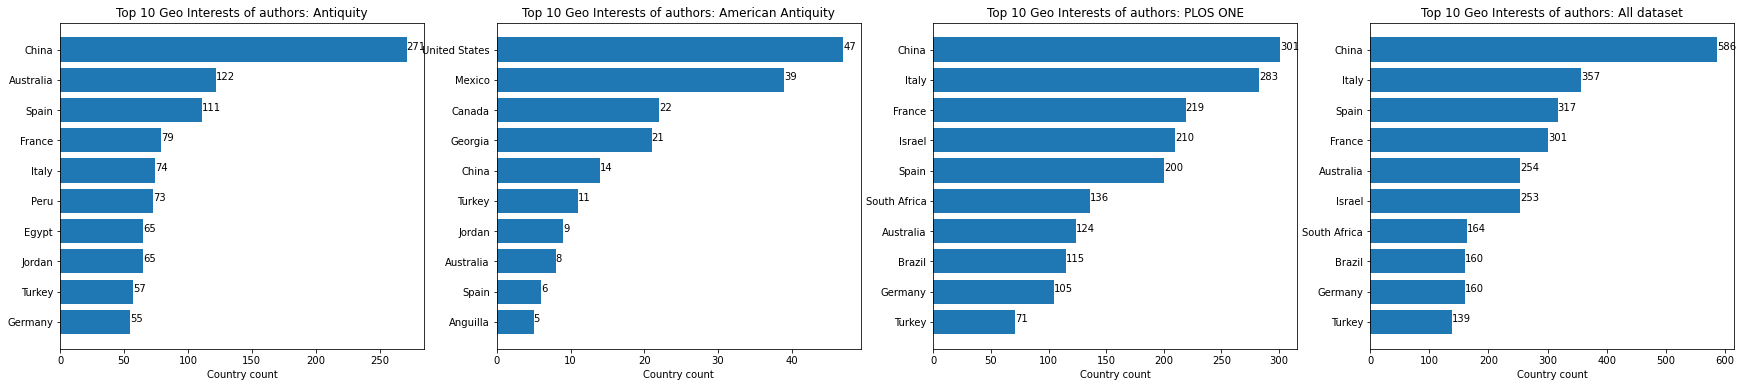

In [169]:
fig, ax = plt.subplots(1,4, figsize = (30,6))
axs = ax.flatten()
max_list = [countrymax_A,countrymax_AA,countrymax_plos,countrymax_all]
name_list = ['Antiquity','American Antiquity','PLOS ONE', 'All dataset']
for i in range(4):
    data = max_list[i]
    y = data['count'].values[::-1]
    x = data.index[::-1]
    axs[i].barh(x, y)
    for index, value in enumerate(y):
        axs[i].text(value, index, str(value))
    axs[i].set_xlabel('Country count')
    axs[i].set_title(f'Top 10 Geo Interests of authors: {name_list[i]}')
plt.show()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

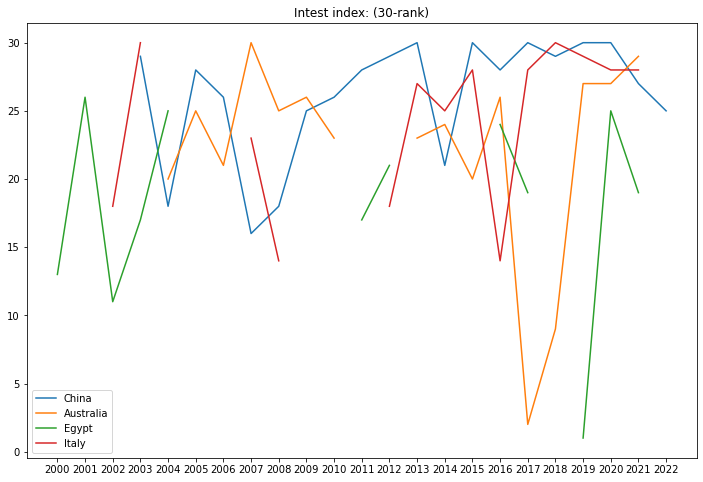

In [124]:
# Popular destination China, Italy, Spain, France, Australia across time 
plt.figure(figsize=(12,8 ))
China_list = []
Australia_list = []
Egypt_list = []
Italy_list = []

year_list = np.unique(Target_country_info_df.Year)

for year in year_list:
    temp = Target_country_info_df[Target_country_info_df.Year == year]
    top = temp.groupby(['Target_Country_clean']).size().nlargest(30).index
    if 'China' in top:
        China_list.append(30 - list(top).index('China'))
    else:
        China_list.append(np.nan)
    if 'Australia' in top:
        Australia_list.append(30 - list(top).index('Australia'))
    else:
        Australia_list.append(np.nan)
    if 'Egypt' in top:
        Egypt_list.append(30 - list(top).index('Egypt'))
    else:
        Egypt_list.append(np.nan)
    if 'Italy' in top:
        Italy_list.append(30 - list(top).index('Italy'))
    else:
        Italy_list.append(np.nan)
   
plt.plot(year_list,China_list,label = 'China')
plt.plot(year_list,Australia_list,label = 'Australia')
plt.plot(year_list,Egypt_list,label = 'Egypt')
plt.plot(year_list,Italy_list,label = 'Italy')

#year_int_list= [int(year) for year in year_list]
#sns.regplot(year_int_list,China_list,ci = None,order =2, label='China')
#sns.regplot(year_int_list,Australia_list,ci = None,order = 2,label='Australia')
#sns.regplot(year_int_list,Egypt_list,ci = None, order =2,label='Egypt')
#sns.regplot(year_int_list,Italy_list,ci = None, order =2,label='Italy')


plt.title('Intest index: (30-rank)')
plt.legend()
plt.show()

In [ ]:
temp2 = Target_country_info_df.groupby(['Journal','Target_Country']).count()

temp2.loc['Antiquity'].sort_values(by = ['country_code','Target_country_code'],ascending = [False,False])

In [97]:


3. Popular destination
for each journal (top 10 country)


SyntaxError: invalid syntax (948854296.py, line 1)

In [98]:
plos_df

,DOI,Journal,Type,Title,Publish_Time,Issue_Time,Co Author,Author,Rank,Nationality,Abs_country,Abs_GPE,Abs_LOC,Nationality_clean,country_code,region_code,GPE,NORP,LOC,ORG,LANG,Year
0,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Abay Namen,First,Kazakhstan,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],Kazakhstan,KZ,AS,['kazakhstan'],,,,,2022
1,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Radu Iovita,Other,United States of America,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],United States,US,NA,['kazakhstan'],,,,,2022
2,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Klaus G. Nickel,Other,Germany,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],Germany,DE,EU,['kazakhstan'],,,,,2022
3,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Aristeidis Varis,Other,Germany,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],Germany,DE,EU,['kazakhstan'],,,,,2022
4,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Zhaken Taimagambetov,Other,Kazakhstan,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],Kazakhstan,KZ,AS,['kazakhstan'],,,,,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6070,https://doi.org/10.1371/journal.pone.0000248,PLOS ONE,Research Article,melanesian mtdna complexity,"February 28, 2007","February 28, 2007",True,George Koki,Other,Papua New Guinea,['32' '16' 'Australia' 'Taiwan'],['Australia' 'Taiwan'],['Island Southeast Asia' 'Island Southeast Asi...,Papua New Guinea,PG,OC,,['melanesian'],,,,2007
6071,https://doi.org/10.1371/journal.pone.0000248,PLOS ONE,Research Article,melanesian mtdna complexity,"February 28, 2007","February 28, 2007",True,Gisele Horvat,Other,United States of America,['32' '16' 'Australia' 'Taiwan'],['Australia' 'Taiwan'],['Island Southeast Asia' 'Island Southeast Asi...,United States,US,NA,,['melanesian'],,,,2007
6072,https://doi.org/10.1371/journal.pone.0000248,PLOS ONE,Research Article,melanesian mtdna complexity,"February 28, 2007","February 28, 2007",True,Sergey Zhadanov,Other,United States of America,['32' '16' 'Australia' 'Taiwan'],['Australia' 'Taiwan'],['Island Southeast Asia' 'Island Southeast Asi...,United States,US,NA,,['melanesian'],,,,2007
6073,https://doi.org/10.1371/journal.pone.0000248,PLOS ONE,Research Article,melanesian mtdna complexity,"February 28, 2007","February 28, 2007",True,Theodore G. Schurr,Other,United States of America,['32' '16' 'Australia' 'Taiwan'],['Australia' 'Taiwan'],['Island Southeast Asia' 'Island Southeast Asi...,United States,US,NA,,['melanesian'],,,,2007


In [99]:
Target_country_info_df

,Abs_country,Abs_GPE,Abs_LOC,GPE,NORP,LOC,ORG,LANG,Target_info,Target_Country,region_code,Journal,country_code,Issue_Time,Year,Target_Country_clean,Target_country_code,Target_cont_code
0,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],['kazakhstan'],,,,,"[, the Inner Asian Mountain Corridor, , the Pa...",kazakhstan,AS,PLOS ONE,KZ,"April 22, 2022",2022,Kazakhstan,KZ,AS
1,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],['kazakhstan'],,,,,"[, the Inner Asian Mountain Corridor, , the Pa...",kazakhstan,NA,PLOS ONE,US,"April 22, 2022",2022,Kazakhstan,KZ,AS
2,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],['kazakhstan'],,,,,"[, the Inner Asian Mountain Corridor, , the Pa...",kazakhstan,EU,PLOS ONE,DE,"April 22, 2022",2022,Kazakhstan,KZ,AS
3,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],['kazakhstan'],,,,,"[, the Inner Asian Mountain Corridor, , the Pa...",kazakhstan,EU,PLOS ONE,DE,"April 22, 2022",2022,Kazakhstan,KZ,AS
4,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],['kazakhstan'],,,,,"[, the Inner Asian Mountain Corridor, , the Pa...",kazakhstan,AS,PLOS ONE,KZ,"April 22, 2022",2022,Kazakhstan,KZ,AS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12196,['Mexico'],['Mexico' 'El Palmillo' 'Kowalewski et al'],['the Valley of Oaxaca'],"['oaxaca', 'mexico']",,,,,"[, Mexico, , Mexico, , El Palmillo, , Kowale...",Mexico,NA,Antiquity,US,March 2000,2000,Mexico,MX,NA
12197,['Mexico'],['Mexico' 'El Palmillo' 'Kowalewski et al'],['the Valley of Oaxaca'],"['oaxaca', 'mexico']",,,,,"[, Mexico, , Mexico, , El Palmillo, , Kowale...",Mexico,NA,Antiquity,US,March 2000,2000,Mexico,MX,NA
12216,[],[],['the Taiwan Strait' 'Pacific'],['taiwan'],['austronesian'],,,,"[, the Taiwan Strait, , Pacific, , taiwan, , ...",taiwan,NA,Antiquity,US,March 2000,2000,Taiwan,TW,AS
12217,[],[],['the Taiwan Strait' 'Pacific'],['taiwan'],['austronesian'],,,,"[, the Taiwan Strait, , Pacific, , taiwan, , ...",taiwan,AS,Antiquity,TW,March 2000,2000,Taiwan,TW,AS


In [50]:
data

,DOI,Journal,Type,Title,Publish_Time,Issue_Time,Co Author,Author,Rank,Nationality,Abs_country,Abs_GPE,Abs_LOC,Nationality_clean,country_code,region_code,GPE,NORP,LOC,ORG,LANG,Co_Author
0,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Abay Namen,First,Kazakhstan,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],Kazakhstan,KZ,AS,['kazakhstan'],,,,,NaN
1,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Radu Iovita,Other,United States of America,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],United States,US,NA,['kazakhstan'],,,,,NaN
2,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Klaus G. Nickel,Other,Germany,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],Germany,DE,EU,['kazakhstan'],,,,,NaN
3,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Aristeidis Varis,Other,Germany,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],Germany,DE,EU,['kazakhstan'],,,,,NaN
4,https://doi.org/10.1371/journal.pone.0265640,PLOS ONE,Research Article,mechanical properties of lithic raw materials ...,"April 22, 2022","April 22, 2022",True,Zhaken Taimagambetov,Other,Kazakhstan,[],['the Inner Asian Mountain Corridor'],['the Palaeolithic of Kazakhstan'],Kazakhstan,KZ,AS,['kazakhstan'],,,,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4973,https://doi.org/10.1017/S0003598X00066138,Antiquity,News and Notes,the use of henbane (hyoscyamus niger l.) as a ...,02 January 2015,March 2000,NaN,M. J. Bunting,Other,United Kingdom,[],[],[],United Kingdom,GB,EU,,,,,,True
4974,https://doi.org/10.1017/S0003598X00066138,Antiquity,News and Notes,the use of henbane (hyoscyamus niger l.) as a ...,02 January 2015,March 2000,NaN,P. Milburn,Communication,United Kingdom,[],[],[],United Kingdom,GB,EU,,,,,,True
4975,https://doi.org/10.1017/S0003598X0006614X,Antiquity,News and Notes,"taiwan, neolithic seafaring and austronesian o...",02 January 2015,March 2000,NaN,Barry V. Rolett,First,United States of America,[],[],['the Taiwan Strait' 'Pacific'],United States,US,NA,['taiwan'],['austronesian'],,,,True
4976,https://doi.org/10.1017/S0003598X0006614X,Antiquity,News and Notes,"taiwan, neolithic seafaring and austronesian o...",02 January 2015,March 2000,NaN,Wei-Chun Chen,Other,Taiwan,[],[],['the Taiwan Strait' 'Pacific'],Taiwan,TW,AS,['taiwan'],['austronesian'],,,,True


In [299]:
data['region_code']

Target_cont_code  Journal           
AF                American Antiquity       4
                  Antiquity              238
                  PLOS ONE               457
AS                American Antiquity      11
                  Antiquity              893
                  PLOS ONE               917
EU                American Antiquity       5
                  Antiquity              731
                  PLOS ONE              1245
NA                American Antiquity       9
                  Antiquity               25
                  PLOS ONE                20
OC                American Antiquity      10
                  Antiquity              155
                  PLOS ONE               161
SA                American Antiquity       2
                  Antiquity              127
                  PLOS ONE               206
Name: region_code, dtype: int64